# first-order Optimization Algorithms by logistic regression
   -  Implementations of:
    - Gradient Descent
    - Nesterov Gradient Descent
    - RMSProp
    - Adagrad
    - Adam
    - Subgradient

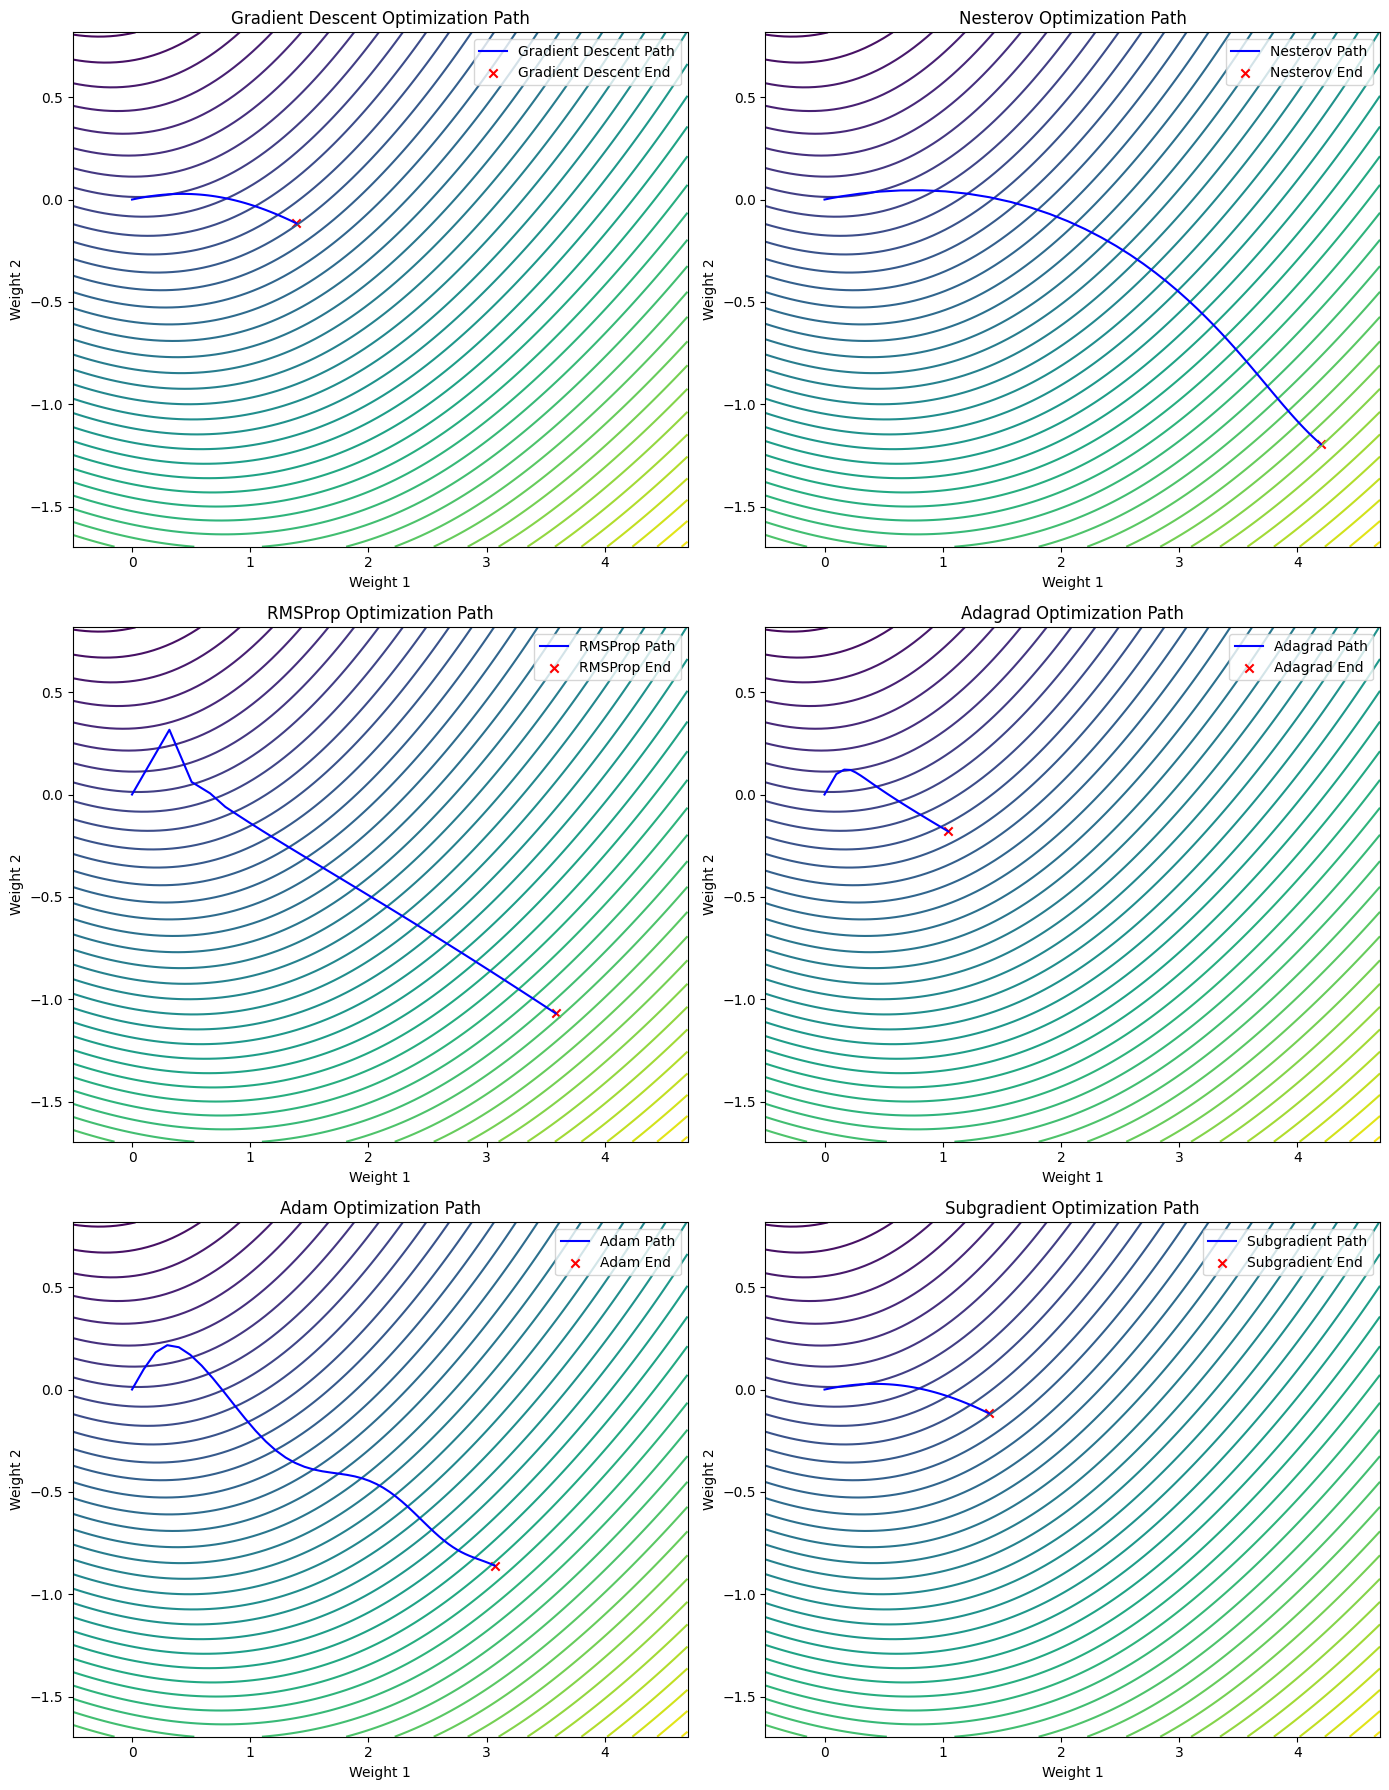

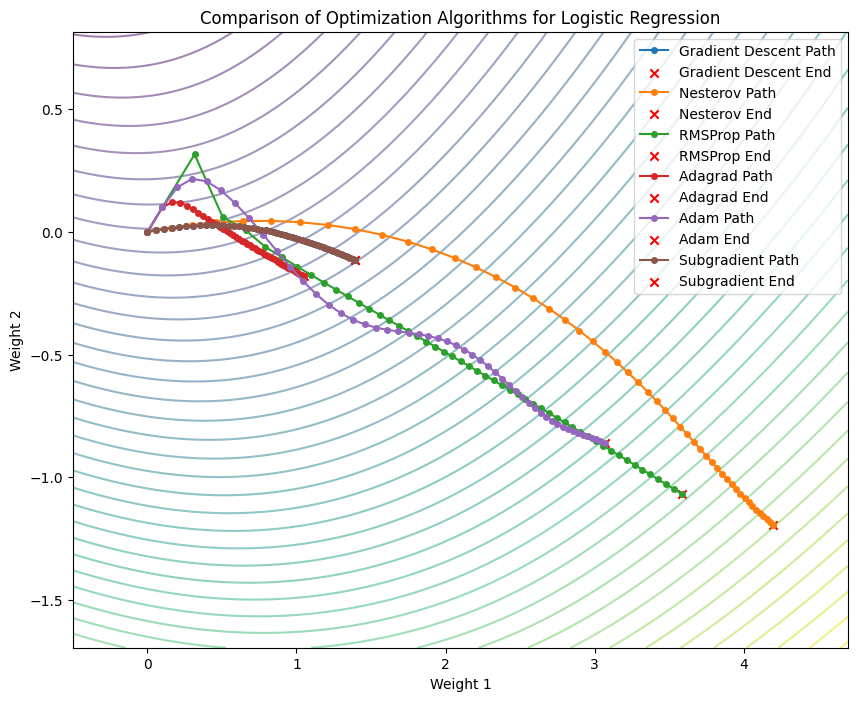

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification

# Logistic regression cost and gradient functions
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def logistic_cost(X, y, weights):
    preds = sigmoid(np.dot(X, weights))
    return -np.mean(y * np.log(preds) + (1 - y) * np.log(1 - preds))

def logistic_gradient(X, y, weights):
    preds = sigmoid(np.dot(X, weights))
    error = preds - y
    grad = np.dot(X.T, error) / len(y)
    return grad

# Optimization Algorithms (First-Order and Second-Order)
class Optimizer:
    def __init__(self, learning_rate=0.01):
        self.learning_rate = learning_rate

    def gradient_descent(self, grad_func, x_init, iterations=100):
        return self._optimize(grad_func, x_init, iterations, method='gd')

    def nesterov(self, grad_func, x_init, iterations=100, momentum=0.9):
        return self._optimize(grad_func, x_init, iterations, method='nesterov', momentum=momentum)

    def rmsprop(self, grad_func, x_init, iterations=100, decay_rate=0.9, epsilon=1e-8):
        return self._optimize(grad_func, x_init, iterations, method='rmsprop', decay_rate=decay_rate, epsilon=epsilon)

    def adagrad(self, grad_func, x_init, iterations=100, epsilon=1e-8):
        return self._optimize(grad_func, x_init, iterations, method='adagrad', epsilon=epsilon)

    def adam(self, grad_func, x_init, iterations=100, beta1=0.9, beta2=0.999, epsilon=1e-8):
        return self._optimize(grad_func, x_init, iterations, method='adam', beta1=beta1, beta2=beta2, epsilon=epsilon)

    def subgradient(self, grad_func, x_init, iterations=100):
        return self._optimize(grad_func, x_init, iterations, method='subgradient')

    def _optimize(self, grad_func, x_init, iterations, method, **kwargs):
        x = x_init
        path = [x]
        m, v, cache = np.zeros_like(x), np.zeros_like(x), np.zeros_like(x)

        for t in range(1, iterations + 1):
            grad = grad_func(x)
            if method == 'gd':
                x = x - self.learning_rate * grad
            elif method == 'nesterov':
                momentum = kwargs.get('momentum', 0.9)
                v = momentum * v - self.learning_rate * grad_func(x + momentum * v)
                x = x + v
            elif method == 'rmsprop':
                decay_rate = kwargs.get('decay_rate', 0.9)
                epsilon = kwargs.get('epsilon', 1e-8)
                cache = decay_rate * cache + (1 - decay_rate) * grad ** 2
                x = x - self.learning_rate * grad / (np.sqrt(cache) + epsilon)
            elif method == 'adagrad':
                epsilon = kwargs.get('epsilon', 1e-8)
                cache += grad ** 2
                x = x - self.learning_rate * grad / (np.sqrt(cache) + epsilon)
            elif method == 'adam':
                beta1, beta2, epsilon = kwargs.get('beta1', 0.9), kwargs.get('beta2', 0.999), kwargs.get('epsilon', 1e-8)
                m = beta1 * m + (1 - beta1) * grad
                v = beta2 * v + (1 - beta2) * (grad ** 2)
                m_hat = m / (1 - beta1 ** t)
                v_hat = v / (1 - beta2 ** t)
                x = x - self.learning_rate * m_hat / (np.sqrt(v_hat) + epsilon)
            elif method == 'subgradient':
                x = x - self.learning_rate * grad

            path.append(x)
        return np.array(path)

# Generate synthetic dataset for binary classification
X, y = make_classification(n_samples=100, n_features=2, n_informative=2, n_redundant=0, n_repeated=0, n_classes=2, random_state=42)
X = np.c_[np.ones(X.shape[0]), X]


x_init = np.zeros(X.shape[1])
iterations = 50
learning_rate = 0.1

# Instantiate the optimizer
optimizer = Optimizer(learning_rate=learning_rate)

# Get paths for each optimizer
paths = {
    'Gradient Descent': optimizer.gradient_descent(lambda w: logistic_gradient(X, y, w), x_init, iterations),
    'Nesterov': optimizer.nesterov(lambda w: logistic_gradient(X, y, w), x_init, iterations),
    'RMSProp': optimizer.rmsprop(lambda w: logistic_gradient(X, y, w), x_init, iterations),
    'Adagrad': optimizer.adagrad(lambda w: logistic_gradient(X, y, w), x_init, iterations),
    'Adam': optimizer.adam(lambda w: logistic_gradient(X, y, w), x_init, iterations),
    'Subgradient': optimizer.subgradient(lambda w: logistic_gradient(X, y, w), x_init, iterations)
}

# Determine contour plot boundaries based on optimizer paths
x_min = min(path[:, 1].min() for path in paths.values()) - 0.5
x_max = max(path[:, 1].max() for path in paths.values()) + 0.5
y_min = min(path[:, 2].min() for path in paths.values()) - 0.5
y_max = max(path[:, 2].max() for path in paths.values()) + 0.5

# Generate contour plot of logistic cost function for visualization
x_vals = np.linspace(x_min, x_max, 100)
y_vals = np.linspace(y_min, y_max, 100)
X_mesh, Y_mesh = np.meshgrid(x_vals, y_vals)
Z = np.array([logistic_cost(X, y, np.array([1, x, y])) for x, y in zip(np.ravel(X_mesh), np.ravel(Y_mesh))]).reshape(X_mesh.shape)

# Plot individual contour plots for each optimizer
fig, axes = plt.subplots(3, 2, figsize=(14, 18))
axes = axes.flatten()

for i, (name, path) in enumerate(paths.items()):
    ax = axes[i]
    ax.contour(X_mesh, Y_mesh, Z, levels=50, cmap='viridis')
    ax.plot(path[:, 1], path[:, 2], label=f"{name} Path", color='blue')
    ax.scatter(path[-1, 1], path[-1, 2], label=f"{name} End", marker='x', color='red')
    ax.set_title(f"{name} Optimization Path")
    ax.set_xlabel("Weight 1")
    ax.set_ylabel("Weight 2")
    ax.legend()

plt.tight_layout()
plt.show()

# Comparison contour plot for all algorithms
plt.figure(figsize=(10, 8))
plt.contour(X_mesh, Y_mesh, Z, levels=50, cmap='viridis', alpha=0.5)
for name, path in paths.items():
    plt.plot(path[:, 1], path[:, 2], label=f"{name} Path", marker='o', markersize=4)
    plt.scatter(path[-1, 1], path[-1, 2], label=f"{name} End", marker='x', color='red')

plt.title("Comparison of Optimization Algorithms for Logistic Regression")
plt.xlabel("Weight 1")
plt.ylabel("Weight 2")
plt.legend(loc='upper right')
plt.show()


# Second-Order Optimization Algorithms by logistic regression
  -  Implementations of:
    - Newton's Method
    - BFGS
    - DFP
    -conjugate gradient

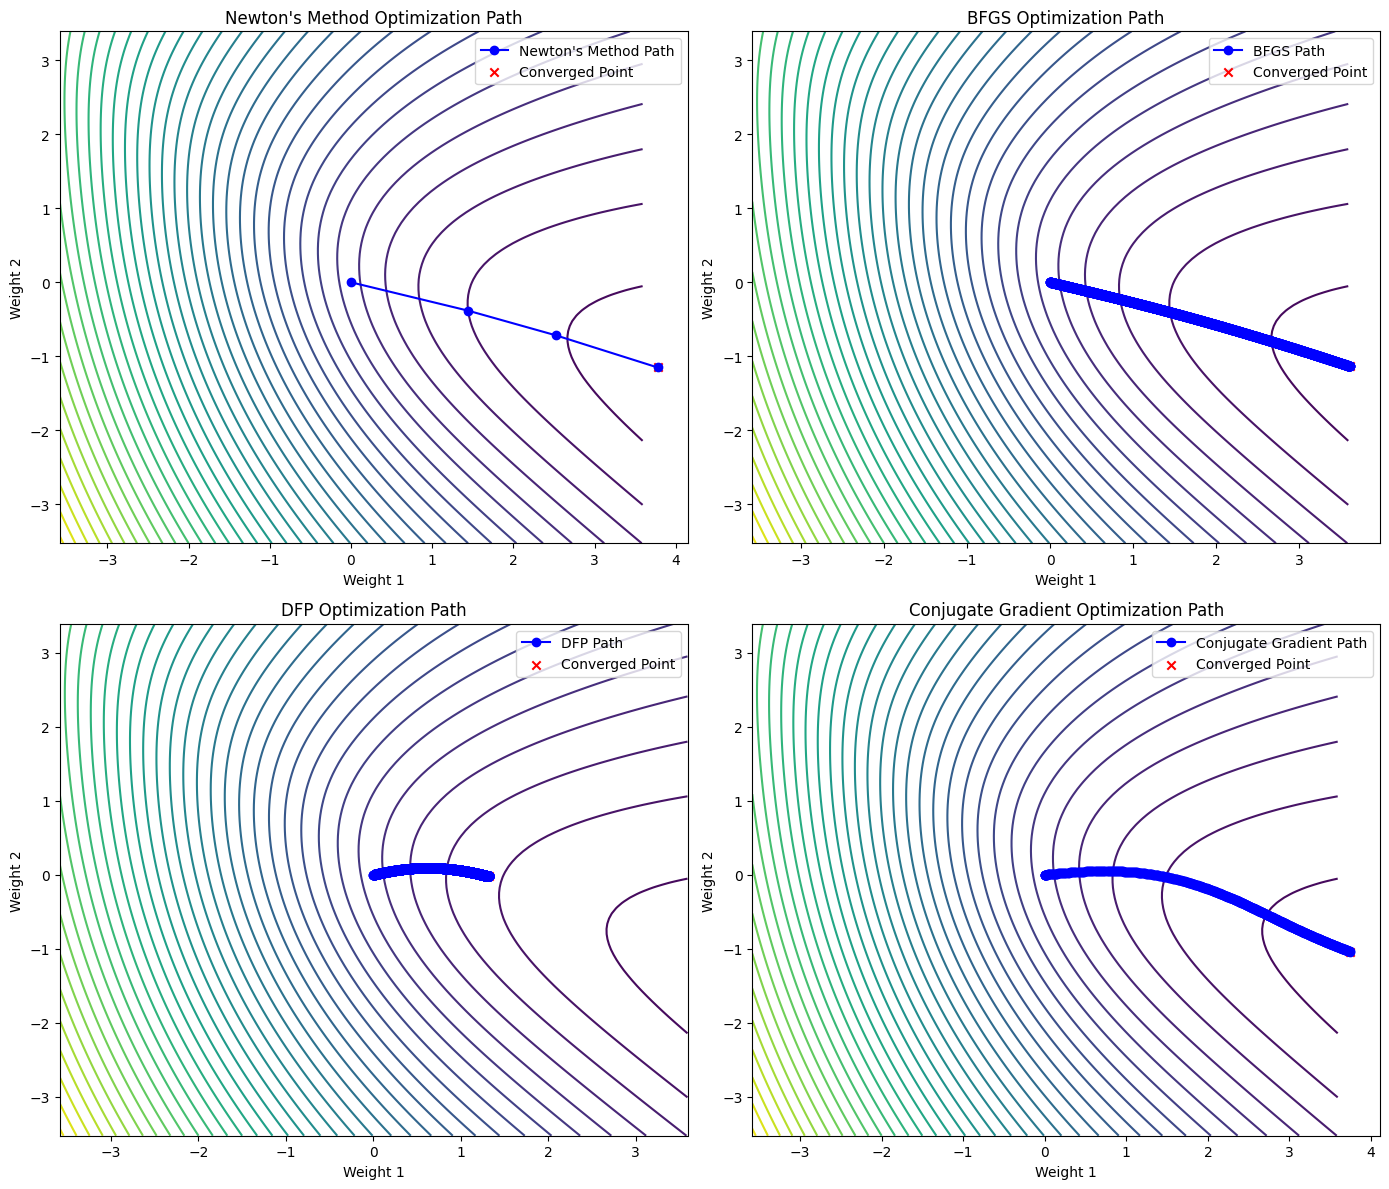

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification

# Logistic regression utility functions
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def logistic_cost(X, y, weights):
    preds = sigmoid(np.dot(X, weights))
    return -np.mean(y * np.log(preds) + (1 - y) * np.log(1 - preds))

def logistic_gradient(X, y, weights):
    preds = sigmoid(np.dot(X, weights))
    error = preds - y
    grad = np.dot(X.T, error) / len(y)
    return grad

def logistic_hessian(X, weights):
    preds = sigmoid(np.dot(X, weights))
    diag = preds * (1 - preds)
    H = X.T @ (np.diag(diag) @ X) / len(y)
    return H

# Optimization algorithms
def newtons_method(X, y, w_init, tol=1e-6, max_iter=3):
    w = w_init
    trajectory = [w]
    for _ in range(max_iter):
        grad = logistic_gradient(X, y, w)
        hess = logistic_hessian(X, w)
        if np.linalg.cond(hess) > 1e10:
            break
        step = np.linalg.inv(hess) @ grad
        w_new = w - step
        trajectory.append(w_new)
        if np.linalg.norm(step) < tol:
            break
        w = w_new
    return w, np.array(trajectory)

def bfgs(X, y, w_init, tol=1e-6, max_iter=3000):
    w = w_init
    B = np.eye(len(w_init))  # Initial Hessian approximation
    trajectory = [w]
    for _ in range(max_iter):
        grad = logistic_gradient(X, y, w)
        p = -np.linalg.inv(B) @ grad
        alpha = 1e-3  # Fixed step size
        w_new = w + alpha * p
        s = (w_new - w).reshape(-1, 1)
        y_k = (logistic_gradient(X, y, w_new) - grad).reshape(-1, 1)
        if np.dot(s.T, y_k) > 0:  # Ensure curvature condition
            B = B + (y_k @ y_k.T) / (y_k.T @ s) - (B @ s @ s.T @ B) / (s.T @ B @ s)
        trajectory.append(w_new)
        if np.linalg.norm(w_new - w) < tol:
            break
        w = w_new
    return w, np.array(trajectory)

def dfp(X, y, w_init, tol=1e-6, max_iter=20000):
    w = w_init
    B = np.eye(len(w_init))  # Initial Hessian approximation
    trajectory = [w]
    for _ in range(max_iter):
        grad = logistic_gradient(X, y, w)
        p = -np.linalg.inv(B) @ grad
        alpha = 1e-3  # Fixed step size
        w_new = w + alpha * p
        s = (w_new - w).reshape(-1, 1)
        y_k = (logistic_gradient(X, y, w_new) - grad).reshape(-1, 1)
        if np.dot(s.T, y_k) > 0:  # Ensure curvature condition
            B = B + (s @ s.T) / (s.T @ y_k) - (B @ y_k @ y_k.T @ B) / (y_k.T @ B @ y_k)
        trajectory.append(w_new)
        if np.linalg.norm(w_new - w) < tol:
            break
        w = w_new
    return w, np.array(trajectory)

def conjugate_gradient(X, y, w_init, tol=1e-6, max_iter=500):
    w = w_init
    grad = logistic_gradient(X, y, w)
    p = -grad
    trajectory = [w]
    for _ in range(max_iter):
        alpha = 1e-3  # Fixed step size
        w_new = w + alpha * p
        grad_new = logistic_gradient(X, y, w_new)
        beta = np.dot(grad_new, grad_new) / np.dot(grad, grad)
        p = -grad_new + beta * p
        trajectory.append(w_new)
        if np.linalg.norm(grad_new) < tol:
            break
        grad = grad_new
        w = w_new
    return w, np.array(trajectory)

# Generate synthetic dataset
X, y = make_classification(n_samples=100, n_features=2, n_informative=2, n_redundant=0, n_classes=2, random_state=42)
X = np.c_[np.ones(X.shape[0]), X]  # Add bias term

# Initialize parameters
w_init = np.zeros(X.shape[1])

# Perform optimization
methods = {
    "Newton's Method": newtons_method,
    "BFGS": bfgs,
    "DFP": dfp,
    "Conjugate Gradient": conjugate_gradient
}
trajectories = {}

for name, method in methods.items():
    _, traj = method(X, y, w_init)
    trajectories[name] = traj

# Plot contours and trajectories
x_min, x_max = X[:, 1].min() - 1, X[:, 1].max() + 1
y_min, y_max = X[:, 2].min() - 1, X[:, 2].max() + 1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100), np.linspace(y_min, y_max, 100))
Z = np.array([logistic_cost(X, y, np.array([1, w1, w2])) for w1, w2 in zip(np.ravel(xx), np.ravel(yy))])
Z = Z.reshape(xx.shape)

fig, axes = plt.subplots(2, 2, figsize=(14, 12))
axes = axes.flatten()

for ax, (name, traj) in zip(axes, trajectories.items()):
    ax.contour(xx, yy, Z, levels=50, cmap='viridis')
    ax.plot(traj[:, 1], traj[:, 2], label=f"{name} Path", color='blue', marker='o')
    ax.scatter(traj[-1, 1], traj[-1, 2], label="Converged Point", color='red', marker='x')
    ax.set_title(f"{name} Optimization Path")
    ax.set_xlabel("Weight 1")
    ax.set_ylabel("Weight 2")
    ax.legend()

plt.tight_layout()
plt.show()

